In [65]:
#%pip install --upgrade --force-reinstall --no-cache-dir --verbose nvidia-nvjitlink-cu12 pynvjitlink-cu12 2>&1 | tee /tmp/pip_nvjitlink_install.log
#%tail -n 200 /tmp/pip_nvjitlink_install.log || true

Optional

In [66]:
'''import os, sys, textwrap

nvfolder = "/usr/local/lib/python3.12/dist-packages/nvidia/nvjitlink/lib"
if not os.path.exists(nvfolder):
    nvfolder = "/usr/local/cuda/targets/x86_64-linux/lib"
print("Using nvjitlink folder:", nvfolder)
os.environ["LD_LIBRARY_PATH"] = nvfolder + ":" + os.environ.get("LD_LIBRARY_PATH", "")
print("LD_LIBRARY_PATH set for this process (will be inherited by child processes):")
print(os.environ["LD_LIBRARY_PATH"])

print("Now restarting the runtime so the loader sees the new LD_LIBRARY_PATH.")
import os, sys
os.kill(os.getpid(), 9)
'''


'import os, sys, textwrap\n\nnvfolder = "/usr/local/lib/python3.12/dist-packages/nvidia/nvjitlink/lib"\nif not os.path.exists(nvfolder):\n    nvfolder = "/usr/local/cuda/targets/x86_64-linux/lib"\nprint("Using nvjitlink folder:", nvfolder)\nos.environ["LD_LIBRARY_PATH"] = nvfolder + ":" + os.environ.get("LD_LIBRARY_PATH", "")\nprint("LD_LIBRARY_PATH set for this process (will be inherited by child processes):")\nprint(os.environ["LD_LIBRARY_PATH"])\n\nprint("Now restarting the runtime so the loader sees the new LD_LIBRARY_PATH.")\nimport os, sys\nos.kill(os.getpid(), 9)\n'

# CPU

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

def plot_protein_structure(positions, title='Protein Folding Structure'):
    from scipy.interpolate import splprep, splev
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.cm as cm

    fig = plt.figure(figsize=(14, 11), facecolor='white')
    ax = fig.add_subplot(111, projection='3d', facecolor='white')

    pos = positions

    if len(pos) > 3:
        tck, u = splprep([pos[:, 0], pos[:, 1], pos[:, 2]], s=2, k=min(3, len(pos)-1))
        u_fine = np.linspace(0, 1, len(pos) * 30)
        x_smooth, y_smooth, z_smooth = splev(u_fine, tck)

        tangents = np.gradient(np.stack([x_smooth, y_smooth, z_smooth]), axis=1)
    else:
        x_smooth, y_smooth, z_smooth = pos[:, 0], pos[:, 1], pos[:, 2]
        tangents = np.gradient(np.stack([x_smooth, y_smooth, z_smooth]), axis=1)

    ribbon_width = 0.08
    n_points = len(x_smooth)

    colors = cm.Blues(np.linspace(0.5, 0.9, n_points))

    prev_perp = None

    for i in range(len(x_smooth) - 1):
        p1 = np.array([x_smooth[i], y_smooth[i], z_smooth[i]])
        p2 = np.array([x_smooth[i + 1], y_smooth[i + 1], z_smooth[i + 1]])

        direction = p2 - p1
        length = np.linalg.norm(direction)

        if length > 1e-6:
            direction = direction / length

            if prev_perp is not None:
                perp = prev_perp - np.dot(prev_perp, direction) * direction
                perp_norm = np.linalg.norm(perp)
                if perp_norm > 1e-6:
                    perp = perp / perp_norm
                else:
                    if abs(direction[2]) < 0.9:
                        perp = np.cross(direction, np.array([0, 0, 1]))
                    else:
                        perp = np.cross(direction, np.array([1, 0, 0]))
                    perp = perp / np.linalg.norm(perp)
            else:
                if abs(direction[2]) < 0.9:
                    perp = np.cross(direction, np.array([0, 0, 1]))
                else:
                    perp = np.cross(direction, np.array([1, 0, 0]))
                perp = perp / np.linalg.norm(perp)

            prev_perp = perp
            perp = perp * ribbon_width

            v1 = p1 + perp
            v2 = p1 - perp
            v3 = p2 - perp
            v4 = p2 + perp

            X = np.array([[v1[0], v4[0]], [v2[0], v3[0]]])
            Y = np.array([[v1[1], v4[1]], [v2[1], v3[1]]])
            Z = np.array([[v1[2], v4[2]], [v2[2], v3[2]]])

            color = colors[i]

            ax.plot_surface(X, Y, Z, color=color, alpha=0.95,
                           shade=True, antialiased=True,
                           linewidth=0, edgecolor='none',
                           lightsource=None, rcount=2, ccount=2)

    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)

    ax.set_axis_off()

    ax.view_init(elev=25, azim=75)
    ax.dist = 10

    plt.tight_layout()
    plt.show()

class MolecularDynamicsSimulator:


    def __init__(self, sequence, temperature=300.0, timestep=0.001, random_seed=42):

        self.sequence = sequence
        self.n_residues = len(sequence)
        self.temperature = temperature
        self.dt = timestep
        self.random_seed = random_seed

        self.kB = 0.0019872041
        self.mass = 100.0

        self.positions = self._initialize_linear()
        self.velocities = self._initialize_velocities()
        self.forces = np.zeros_like(self.positions)

        self.time = 0.0
        self.energy_history = {'potential': [], 'kinetic': [], 'total': []}
        self.temperature_history = []

    def _initialize_linear(self):

        positions = np.zeros((self.n_residues, 3))
        positions[:, 0] = np.arange(self.n_residues) * 3.8
        return positions

    def _initialize_velocities(self):

        np.random.seed(self.random_seed)

        velocities = np.random.randn(self.n_residues, 3)

        velocities -= np.mean(velocities, axis=0)

        current_temp = self._calculate_temperature(velocities)
        scale_factor = np.sqrt(self.temperature / current_temp)
        velocities *= scale_factor

        return velocities

    def _calculate_temperature(self, velocities):

        ke = 0.5 * self.mass * np.sum(velocities ** 2)

        dof = 3 * self.n_residues - 3
        return 2 * ke / (dof * self.kB)

    def _calculate_forces(self, positions):

        forces = np.zeros_like(positions)

        for i in range(self.n_residues - 1):
            r_vec = positions[i+1] - positions[i]
            r = np.linalg.norm(r_vec)
            r0 = 3.8
            k_bond = 200.0

            force_magnitude = -2 * k_bond * (r - r0)
            force = force_magnitude * r_vec / r

            forces[i] -= force
            forces[i+1] += force

        for i in range(self.n_residues - 2):

            r1 = positions[i+1] - positions[i]
            r2 = positions[i+2] - positions[i+1]

            r1_norm = r1 / np.linalg.norm(r1)
            r2_norm = r2 / np.linalg.norm(r2)

            cos_theta = np.dot(r1_norm, r2_norm)
            cos_theta = np.clip(cos_theta, -1, 1)
            theta = np.arccos(cos_theta)

            theta0 = np.pi * 2/3
            k_angle = 50.0
            force_constant = -2 * k_angle * (theta - theta0)

            if np.abs(np.sin(theta)) > 1e-6:
                forces[i+1] += force_constant * 0.1 * (r1_norm - r2_norm)

        for i in range(self.n_residues):
            for j in range(i + 2, self.n_residues):
                r_vec = positions[j] - positions[i]
                r = np.linalg.norm(r_vec)

                if r < 20.0:
                    sigma = 4.0
                    epsilon = 1.0

                    if self.sequence[i] == 'H' and self.sequence[j] == 'H':
                        epsilon = 2.0
                    elif self.sequence[i] == 'P' and self.sequence[j] == 'P':
                        epsilon = 0.3
                    else:
                        epsilon = 0.8

                    sr6 = (sigma / r) ** 6
                    sr12 = sr6 ** 2

                    force_magnitude = 24 * epsilon * (2 * sr12 - sr6) / r
                    force = force_magnitude * r_vec / r

                    forces[i] += force
                    forces[j] -= force

        return forces

    def _calculate_potential_energy(self, positions):
        energy = 0.0

        for i in range(self.n_residues - 1):
            r = np.linalg.norm(positions[i+1] - positions[i])
            r0 = 3.8
            k_bond = 200.0
            energy += k_bond * (r - r0) ** 2

        for i in range(self.n_residues):
            for j in range(i + 2, self.n_residues):
                r = np.linalg.norm(positions[j] - positions[i])

                if r < 20.0:
                    sigma = 4.0
                    epsilon = 1.0

                    if self.sequence[i] == 'H' and self.sequence[j] == 'H':
                        epsilon = 2.0
                    elif self.sequence[i] == 'P' and self.sequence[j] == 'P':
                        epsilon = 0.3
                    else:
                        epsilon = 0.8

                    sr6 = (sigma / r) ** 6
                    sr12 = sr6 ** 2
                    energy += 4 * epsilon * (sr12 - sr6)

        return energy

    def _calculate_kinetic_energy(self, velocities):
        return 0.5 * self.mass * np.sum(velocities ** 2)

    def _velocity_verlet_step(self):

        self.positions += self.velocities * self.dt + 0.5 * self.forces / self.mass * self.dt**2

        old_forces = self.forces.copy()
        self.forces = self._calculate_forces(self.positions)

        self.velocities += 0.5 * (old_forces + self.forces) / self.mass * self.dt

        self.time += self.dt

    def _thermostat(self):

        current_temp = self._calculate_temperature(self.velocities)
        tau = 0.1  # Coupling time constant (ps)
        lambda_scale = np.sqrt(1 + (self.dt / tau) * (self.temperature / current_temp - 1))
        self.velocities *= lambda_scale

    def simulate(self, n_steps=10000, thermostat_interval=10):

        print(f"Starting MD simulation...")
        print(f"Temperature: {self.temperature} K")
        print(f"Timestep: {self.dt} ps")
        print(f"Total time: {n_steps * self.dt} ps")
        print(f"Random seed: {self.random_seed}\n")

        for step in range(n_steps):

            self._velocity_verlet_step()

            if step % thermostat_interval == 0:
                self._thermostat()

            if step % 10 == 0:
                pe = self._calculate_potential_energy(self.positions)
                ke = self._calculate_kinetic_energy(self.velocities)
                temp = self._calculate_temperature(self.velocities)

                self.energy_history['potential'].append(pe)
                self.energy_history['kinetic'].append(ke)
                self.energy_history['total'].append(pe + ke)
                self.temperature_history.append(temp)

            if step % 1000 == 0:
                pe = self._calculate_potential_energy(self.positions)
                ke = self._calculate_kinetic_energy(self.velocities)
                temp = self._calculate_temperature(self.velocities)
                print(f"Step {step}/{n_steps} | Time: {self.time:.2f} ps | "
                      f"PE: {pe:.2f} | KE: {ke:.2f} | T: {temp:.1f} K")

        print(f"\nSimulation complete! Total time: {self.time:.2f} ps")

    def plot_results(self):
        plot_protein_structure(self.positions, 'Protein Folding Structure (CPU)')

    def calculate_rmsd(self, reference_positions):
        pos_centered = self.positions - np.mean(self.positions, axis=0)
        ref_centered = reference_positions - np.mean(reference_positions, axis=0)

        rmsd = np.sqrt(np.mean(np.sum((pos_centered - ref_centered)**2, axis=1)))
        return rmsd

# Dynamics of Forces
This method is crucial as it determines how each atom in the protein interacts with others, driving the protein's movement and conformation. It calculates three main types of forces:

## Bonded Interactions (Harmonic Bonds):

Purpose: These forces maintain the covalent bonds between adjacent residues, essentially acting like springs connecting them. They prevent the protein chain from breaking or collapsing too tightly.
Mechanism: A harmonic potential V = k * (r - r0)^2 is used. r is the current distance between two bonded atoms, and r0 is the ideal (equilibrium) bond length. k_bond is the spring constant.
Force Calculation: The force is the negative derivative of the potential with respect to distance (-dV/dr). This results in a force that pulls atoms together if they are too far apart (r > r0) and pushes them apart if they are too close (r < r0). The force acts along the vector connecting the two atoms.

## Angle Bending Interactions (Harmonic Angles):

Purpose: These forces maintain the preferred bond angles between three sequentially connected residues. For example, in a protein backbone, the angle formed by three consecutive alpha carbons (or in this simplified model, three consecutive residues) will have a preferred value.
Mechanism: A harmonic potential based on the angle θ between two connected bonds is used. θ0 is the ideal (equilibrium) angle, and k_angle is the angle bending constant.
Force Calculation: The force tends to restore the angle to θ0 if it deviates. The implementation here applies a force to the central atom of the three, proportional to the deviation from θ0 and influencing the directions of the bonds.

## Non-Bonded Interactions (Lennard-Jones Potential):

Purpose: These forces account for interactions between all atoms that are not directly bonded or part of the same angle (i.e., not first or second neighbors). They are critical for determining the overall shape of the protein, including its packing and hydrophobic core formation.
Mechanism: The Lennard-Jones (LJ) potential V = 4*epsilon*[(sigma/r)^12 - (sigma/r)^6] is used. This potential describes both short-range repulsion (due to electron cloud overlap, the r^-12 term) and long-range attraction (van der Waals forces, the r^-6 term). r is the distance between two non-bonded atoms, sigma defines the effective size of the atom, and epsilon determines the depth of the potential well (strength of the interaction).
Hydrophobic/Polar Tuning: A key aspect here is the modification of epsilon based on the residue types ('H' for hydrophobic, 'P' for polar). This allows for differential interactions:
H-H interactions have a stronger epsilon (2.0), leading to stronger attraction, mimicking the hydrophobic effect (where hydrophobic residues cluster together to minimize contact with water).
P-P interactions have a weaker epsilon (0.3), resulting in weaker repulsion/attraction.
H-P interactions have an intermediate epsilon (0.8).
Force Calculation: Similar to bonded forces, the LJ force is the negative derivative of the LJ potential. It's attractive at longer distances and strongly repulsive at very short distances, preventing atoms from overlapping.
By summing up all these forces on each individual residue, the _calculate_forces method determines the net force acting on every part of the protein, which then dictates its acceleration and subsequent movement in the simulation.


# How is potential energy put into play

The _calculate_forces method is where all the potential energy functions (bond, angle, Lennard-Jones) are converted into forces. These forces then directly drive the changes between potential and kinetic energy in the simulation.

Here's how that conversion happens:

## Forces from Potential Energy:
The _calculate_forces method computes the net force on each particle. Each of these forces (e.g., spring-like forces for bonds, attractive/repulsive forces for non-bonded interactions) is derived from a specific potential energy function. Essentially, a force is the negative gradient of the potential energy with respect to position (F = -∇V). This means that forces always act to reduce the potential energy of the system.

## Forces Cause Acceleration (Newton's Second Law):
Once the forces are calculated, the simulation applies Newton's second law: F = ma (Force equals mass times acceleration). This means that a net force on a particle will cause it to accelerate.

## Acceleration Changes Velocity:
Acceleration is the rate of change of velocity. So, if a particle experiences a force, its velocity will change over a given time step (dt).

## Changing Velocity Means Changing Kinetic Energy:
Kinetic energy is defined as KE = 0.5 * mass * velocity^2. Therefore, any change in a particle's velocity directly results in a change in its kinetic energy.

## Interconversion: Work and Energy:

When particles move downhill on the potential energy landscape (i.e., in the direction of the forces acting on them), the potential energy of the system decreases. This released potential energy is converted into kinetic energy, causing the particles to speed up.
Conversely, when particles move uphill on the potential energy landscape (i.e., against the direction of the forces), they are effectively doing work against those forces. This work is done at the expense of their kinetic energy, which is then converted into stored potential energy, causing the particles to slow down.
The Velocity Verlet Integrator: The _velocity_verlet_step method is the numerical algorithm that performs this dance. It uses the forces (derived from potential energy) to update positions and velocities (which determine kinetic energy) in a way that conserves total energy (kinetic + potential) in an ideal, isolated system.

### Dynamics Behind Temperature Calculation

The temperature in a Molecular Dynamics (MD) simulation is a measure of the average kinetic energy of the particles in the system. The relationship used in the `_calculate_temperature` method is directly derived from the **Equipartition Theorem** of classical statistical mechanics.

**Equipartition Theorem:**

The theorem states that, for a system in thermodynamic equilibrium, each quadratic term in the expression for the total energy of a particle contributes `0.5 * kB * T` to the average energy of the particle, where:
*   `kB` is the Boltzmann constant.
*   `T` is the absolute temperature of the system.

In our molecular dynamics system:

1.  **Degrees of Freedom:** Each particle (residue) in a 3D simulation can move independently in the x, y, and z directions. Its kinetic energy is given by `0.5 * m * (vx^2 + vy^2 + vz^2)`. Each `v^2` term is a quadratic term, contributing to the energy.
    *   Thus, each atom has 3 translational degrees of freedom.
    *   For a system with `N` atoms, there are `3N` total degrees of freedom.

2.  **Constraint for Center of Mass:** In many MD simulations, including this one, the overall translation of the entire system (the movement of its center of mass) is removed to prevent the system from drifting. This removes 3 degrees of freedom (one for each spatial dimension for the center of mass).
    *   Therefore, the effective degrees of freedom (`dof`) for kinetic energy calculation become `3N - 3`.

3.  **Relating Total Kinetic Energy to Temperature:**
    *   According to the equipartition theorem, the total average kinetic energy (`KE_total`) of the system is the sum of the average kinetic energy over all active degrees of freedom:
        `KE_total = dof * (0.5 * kB * T)`

    *   Rearranging this equation to solve for `T` gives the formula used in the code:
        `T = (2 * KE_total) / (dof * kB)`

**In summary:** The `_calculate_temperature` method computes the total kinetic energy from the current velocities of all particles and then uses the equipartition theorem to convert this kinetic energy into a macroscopic temperature value, considering the number of active degrees of freedom in the system.

GPU


In [68]:
from numba import config
config.CUDA_DEFAULT_PTX_VERSION = 8.4
config.CUDA_ENABLE_PYNVJITLINK = 1

In [69]:


import numpy as np
import random
import matplotlib.pyplot as plt
from numba import cuda, float64, int32
import math
import time
import warnings



TILE_SIZE = 32
EPSILON_TABLE = np.array([2.0, 0.8, 0.8, 0.3], dtype=np.float64)


@cuda.jit
def zero_forces_kernel(forces, n):
    idx = cuda.grid(1)
    if idx < n:
        forces[idx, 0] = 0.0
        forces[idx, 1] = 0.0
        forces[idx, 2] = 0.0


@cuda.jit
def update_positions_kernel(positions, velocities, forces, mass, dt, n):
    idx = cuda.grid(1)
    if idx < n:
        factor = 0.5 * dt * dt / mass
        positions[idx, 0] += velocities[idx, 0] * dt + forces[idx, 0] * factor
        positions[idx, 1] += velocities[idx, 1] * dt + forces[idx, 1] * factor
        positions[idx, 2] += velocities[idx, 2] * dt + forces[idx, 2] * factor


@cuda.jit
def update_velocities_kernel(velocities, old_forces, new_forces, mass, dt, n):
    idx = cuda.grid(1)
    if idx < n:
        factor = 0.5 * dt / mass
        velocities[idx, 0] += (old_forces[idx, 0] + new_forces[idx, 0]) * factor
        velocities[idx, 1] += (old_forces[idx, 1] + new_forces[idx, 1]) * factor
        velocities[idx, 2] += (old_forces[idx, 2] + new_forces[idx, 2]) * factor


@cuda.jit
def apply_thermostat_kernel(velocities, scale, n):
    idx = cuda.grid(1)
    if idx < n:
        velocities[idx, 0] *= scale
        velocities[idx, 1] *= scale
        velocities[idx, 2] *= scale


@cuda.jit
def calculate_bonded_forces_kernel(positions, forces, n, k_bond, r0):
    idx = cuda.grid(1)
    if idx < n - 1:
        dx = positions[idx + 1, 0] - positions[idx, 0]
        dy = positions[idx + 1, 1] - positions[idx, 1]
        dz = positions[idx + 1, 2] - positions[idx, 2]

        r = math.sqrt(dx * dx + dy * dy + dz * dz)

        if r > 1e-10:
            force_mag = -2.0 * k_bond * (r - r0)
            inv_r = 1.0 / r

            fx = force_mag * dx * inv_r
            fy = force_mag * dy * inv_r
            fz = force_mag * dz * inv_r

            cuda.atomic.add(forces, (idx, 0), -fx)
            cuda.atomic.add(forces, (idx, 1), -fy)
            cuda.atomic.add(forces, (idx, 2), -fz)

            cuda.atomic.add(forces, (idx + 1, 0), fx)
            cuda.atomic.add(forces, (idx + 1, 1), fy)
            cuda.atomic.add(forces, (idx + 1, 2), fz)


@cuda.jit
def calculate_angle_forces_kernel(positions, forces, n, k_angle, theta0):
    idx = cuda.grid(1)
    if idx < n - 2:
        r1x = positions[idx + 1, 0] - positions[idx, 0]
        r1y = positions[idx + 1, 1] - positions[idx, 1]
        r1z = positions[idx + 1, 2] - positions[idx, 2]

        r2x = positions[idx + 2, 0] - positions[idx + 1, 0]
        r2y = positions[idx + 2, 1] - positions[idx + 1, 1]
        r2z = positions[idx + 2, 2] - positions[idx + 1, 2]

        r1_len = math.sqrt(r1x*r1x + r1y*r1y + r1z*r1z)
        r2_len = math.sqrt(r2x*r2x + r2y*r2y + r2z*r2z)

        if r1_len > 1e-10 and r2_len > 1e-10:
            r1_norm_x = r1x / r1_len
            r1_norm_y = r1y / r1_len
            r1_norm_z = r1z / r1_len

            r2_norm_x = r2x / r2_len
            r2_norm_y = r2y / r2_len
            r2_norm_z = r2z / r2_len

            cos_theta = r1_norm_x*r2_norm_x + r1_norm_y*r2_norm_y + r1_norm_z*r2_norm_z
            cos_theta = max(-1.0, min(1.0, cos_theta))
            theta = math.acos(cos_theta)

            force_constant = -2.0 * k_angle * (theta - theta0)

            if abs(math.sin(theta)) > 1e-6:
                factor = force_constant * 0.1
                cuda.atomic.add(forces, (idx+1, 0), factor * (r1_norm_x - r2_norm_x))
                cuda.atomic.add(forces, (idx+1, 1), factor * (r1_norm_y - r2_norm_y))
                cuda.atomic.add(forces, (idx+1, 2), factor * (r1_norm_z - r2_norm_z))


@cuda.jit
def calculate_nonbonded_forces_tiled_kernel(positions, forces, sequence,
                                             epsilon_table, n, sigma, cutoff):

    tile_pos = cuda.shared.array(shape=(TILE_SIZE, 3), dtype=float64)
    tile_seq = cuda.shared.array(shape=TILE_SIZE, dtype=int32)

    tid = cuda.threadIdx.x
    i = cuda.blockIdx.x * cuda.blockDim.x + tid

    fx_i = 0.0
    fy_i = 0.0
    fz_i = 0.0

    pos_i_x, pos_i_y, pos_i_z = 0.0, 0.0, 0.0
    seq_i = 0

    if i < n:
        pos_i_x = positions[i, 0]
        pos_i_y = positions[i, 1]
        pos_i_z = positions[i, 2]
        seq_i = sequence[i]

    num_tiles = (n + TILE_SIZE - 1) // TILE_SIZE
    cutoff_sq = cutoff * cutoff

    for tile_idx in range(num_tiles):
        tile_start = tile_idx * TILE_SIZE
        j_load = tile_start + tid

        if j_load < n:
            tile_pos[tid, 0] = positions[j_load, 0]
            tile_pos[tid, 1] = positions[j_load, 1]
            tile_pos[tid, 2] = positions[j_load, 2]
            tile_seq[tid] = sequence[j_load]
        else:
            tile_pos[tid, 0] = 1e10
            tile_pos[tid, 1] = 1e10
            tile_pos[tid, 2] = 1e10
            tile_seq[tid] = 0

        cuda.syncthreads()

        if i < n:
            for k in range(TILE_SIZE):
                j = tile_start + k

                if j < n and j > i + 1:
                    dx = tile_pos[k, 0] - pos_i_x
                    dy = tile_pos[k, 1] - pos_i_y
                    dz = tile_pos[k, 2] - pos_i_z

                    r_sq = dx*dx + dy*dy + dz*dz

                    if r_sq < cutoff_sq and r_sq > 1e-12:
                        r = math.sqrt(r_sq)
                        inv_r = 1.0 / r

                        eps_idx = seq_i * 2 + tile_seq[k]
                        epsilon = epsilon_table[eps_idx]

                        sr = sigma * inv_r
                        sr2 = sr * sr
                        sr6 = sr2 * sr2 * sr2
                        sr12 = sr6 * sr6

                        force_mag = 24.0 * epsilon * (2.0 * sr12 - sr6) * inv_r

                        fx = force_mag * dx * inv_r
                        fy = force_mag * dy * inv_r
                        fz = force_mag * dz * inv_r

                        fx_i += fx
                        fy_i += fy
                        fz_i += fz

                        cuda.atomic.add(forces, (j, 0), -fx)
                        cuda.atomic.add(forces, (j, 1), -fy)
                        cuda.atomic.add(forces, (j, 2), -fz)

        cuda.syncthreads()

    if i < n:
        cuda.atomic.add(forces, (i, 0), fx_i)
        cuda.atomic.add(forces, (i, 1), fy_i)
        cuda.atomic.add(forces, (i, 2), fz_i)


@cuda.jit
def calculate_kinetic_energy_kernel(velocities, mass, energies, n):
    idx = cuda.grid(1)
    if idx < n:
        v_sq = (velocities[idx, 0]**2 + velocities[idx, 1]**2 + velocities[idx, 2]**2)
        energies[idx] = 0.5 * mass * v_sq


@cuda.jit
def calculate_bond_energy_kernel(positions, energies, n, k_bond, r0):
    idx = cuda.grid(1)
    if idx < n - 1:
        dx = positions[idx+1, 0] - positions[idx, 0]
        dy = positions[idx+1, 1] - positions[idx, 1]
        dz = positions[idx+1, 2] - positions[idx, 2]
        r = math.sqrt(dx*dx + dy*dy + dz*dz)
        energies[idx] = k_bond * (r - r0) ** 2


@cuda.jit
def calculate_nb_energy_tiled_kernel(positions, sequence, epsilon_table,
                                      energies, n, sigma, cutoff):
    tile_pos = cuda.shared.array(shape=(TILE_SIZE, 3), dtype=float64)
    tile_seq = cuda.shared.array(shape=TILE_SIZE, dtype=int32)

    tid = cuda.threadIdx.x
    i = cuda.blockIdx.x * cuda.blockDim.x + tid

    local_e = 0.0
    pos_i_x, pos_i_y, pos_i_z = 0.0, 0.0, 0.0
    seq_i = 0

    if i < n:
        pos_i_x = positions[i, 0]
        pos_i_y = positions[i, 1]
        pos_i_z = positions[i, 2]
        seq_i = sequence[i]

    cutoff_sq = cutoff * cutoff
    num_tiles = (n + TILE_SIZE - 1) // TILE_SIZE

    for tile_idx in range(num_tiles):
        tile_start = tile_idx * TILE_SIZE
        j_load = tile_start + tid

        if j_load < n:
            tile_pos[tid, 0] = positions[j_load, 0]
            tile_pos[tid, 1] = positions[j_load, 1]
            tile_pos[tid, 2] = positions[j_load, 2]
            tile_seq[tid] = sequence[j_load]
        else:
            tile_pos[tid, 0] = 1e10
            tile_pos[tid, 1] = 1e10
            tile_pos[tid, 2] = 1e10
            tile_seq[tid] = 0

        cuda.syncthreads()

        if i < n:
            for k in range(TILE_SIZE):
                j = tile_start + k
                if j < n and j > i + 1:
                    dx = tile_pos[k, 0] - pos_i_x
                    dy = tile_pos[k, 1] - pos_i_y
                    dz = tile_pos[k, 2] - pos_i_z

                    r_sq = dx*dx + dy*dy + dz*dz

                    if r_sq < cutoff_sq and r_sq > 1e-12:
                        r = math.sqrt(r_sq)
                        eps_idx = seq_i * 2 + tile_seq[k]
                        epsilon = epsilon_table[eps_idx]

                        sr6 = (sigma / r) ** 6
                        sr12 = sr6 * sr6
                        local_e += 4.0 * epsilon * (sr12 - sr6)

        cuda.syncthreads()

    if i < n:
        energies[i] = local_e


@cuda.jit
def parallel_sum_reduction(data, result, n):

    sdata = cuda.shared.array(256, dtype=float64)

    tid = cuda.threadIdx.x
    i = cuda.blockIdx.x * cuda.blockDim.x + tid

    sdata[tid] = data[i] if i < n else 0.0
    cuda.syncthreads()

    s = cuda.blockDim.x // 2
    while s > 0:
        if tid < s and (i + s) < n:
            sdata[tid] += sdata[tid + s]
        cuda.syncthreads()
        s //= 2

    if tid == 0:
        cuda.atomic.add(result, 0, sdata[0])



class MDCudaSimulator:


    def __init__(self, sequence, temperature=300.0, timestep=0.001,
                 device_id=0, random_seed=42):
        cuda.select_device(device_id)

        self.sequence_str = sequence
        self.n = len(sequence)
        self.temperature = temperature
        self.dt = timestep
        self.random_seed = random_seed

        self.kB = 0.0019872041
        self.mass = 100.0
        self.k_bond = 200.0
        self.r0 = 3.8
        self.k_angle = 50.0
        self.theta0 = np.pi * 2 / 3
        self.sigma = 4.0
        self.cutoff = 20.0

        self.sequence = np.array([0 if aa == 'H' else 1 for aa in sequence],
                                  dtype=np.int32)

        self.positions_cpu = self._init_positions()
        self.velocities_cpu = self._init_velocities()

        self.positions_gpu = cuda.to_device(self.positions_cpu)
        self.velocities_gpu = cuda.to_device(self.velocities_cpu)
        self.forces_gpu = cuda.device_array((self.n, 3), dtype=np.float64)
        self.old_forces_gpu = cuda.device_array((self.n, 3), dtype=np.float64)
        self.sequence_gpu = cuda.to_device(self.sequence)
        self.epsilon_table_gpu = cuda.to_device(EPSILON_TABLE)

        self.ke_gpu = cuda.device_array(self.n, dtype=np.float64)
        self.bond_e_gpu = cuda.device_array(self.n, dtype=np.float64)
        self.nb_e_gpu = cuda.device_array(self.n, dtype=np.float64)
        self.sum_gpu = cuda.device_array(1, dtype=np.float64)

        self.threads = 256
        self.blocks = max(1, (self.n + 255) // 256)
        self.threads_tiled = TILE_SIZE
        self.blocks_tiled = max(1, (self.n + TILE_SIZE - 1) // TILE_SIZE)

        self._calc_forces()

        self.time = 0.0
        self.energy_history = {'potential': [], 'kinetic': [], 'total': []}
        self.temperature_history = []


    def _init_positions(self):
        pos = np.zeros((self.n, 3), dtype=np.float64)
        pos[:, 0] = np.arange(self.n) * self.r0
        return pos

    def _init_velocities(self):
        np.random.seed(self.random_seed)
        vel = np.random.randn(self.n, 3).astype(np.float64)
        vel -= np.mean(vel, axis=0)

        ke = 0.5 * self.mass * np.sum(vel ** 2)
        dof = 3 * self.n - 3
        temp = 2 * ke / (dof * self.kB)
        vel *= np.sqrt(self.temperature / temp)
        return vel

    def _calc_forces(self):
        zero_forces_kernel[self.blocks, self.threads](self.forces_gpu, self.n)

        calculate_bonded_forces_kernel[self.blocks, self.threads](
            self.positions_gpu, self.forces_gpu, self.n, self.k_bond, self.r0)

        calculate_angle_forces_kernel[self.blocks, self.threads](
            self.positions_gpu, self.forces_gpu, self.n, self.k_angle, self.theta0)

        calculate_nonbonded_forces_tiled_kernel[self.blocks_tiled, self.threads_tiled](
            self.positions_gpu, self.forces_gpu, self.sequence_gpu,
            self.epsilon_table_gpu, self.n, self.sigma, self.cutoff)

    def _calc_temp(self):
        calculate_kinetic_energy_kernel[self.blocks, self.threads](
            self.velocities_gpu, self.mass, self.ke_gpu, self.n)

        self.sum_gpu[:] = 0
        parallel_sum_reduction[self.blocks, 256](self.ke_gpu, self.sum_gpu, self.n)

        ke = self.sum_gpu.copy_to_host()[0]
        dof = 3 * self.n - 3
        return 2 * ke / (dof * self.kB), ke

    def _apply_thermostat(self):
        temp, ke = self._calc_temp()
        tau = 0.1
        scale = np.sqrt(1 + (self.dt / tau) * (self.temperature / temp - 1))
        apply_thermostat_kernel[self.blocks, self.threads](
            self.velocities_gpu, scale, self.n)
        return temp, ke

    def _calc_energy(self):
        self.sum_gpu[:] = 0
        parallel_sum_reduction[self.blocks, 256](self.ke_gpu, self.sum_gpu, self.n)
        ke = self.sum_gpu.copy_to_host()[0]

        calculate_bond_energy_kernel[self.blocks, self.threads](
            self.positions_gpu, self.bond_e_gpu, self.n, self.k_bond, self.r0)

        self.sum_gpu[:] = 0
        parallel_sum_reduction[self.blocks, 256](self.bond_e_gpu, self.sum_gpu, self.n - 1)
        bond_e = self.sum_gpu.copy_to_host()[0]

        calculate_nb_energy_tiled_kernel[self.blocks_tiled, self.threads_tiled](
            self.positions_gpu, self.sequence_gpu, self.epsilon_table_gpu,
            self.nb_e_gpu, self.n, self.sigma, self.cutoff)

        self.sum_gpu[:] = 0
        parallel_sum_reduction[self.blocks, 256](self.nb_e_gpu, self.sum_gpu, self.n)
        nb_e = self.sum_gpu.copy_to_host()[0]

        return bond_e + nb_e, ke

    def simulate(self, n_steps=10000, thermo_interval=10,
                 record_interval=100, report_interval=1000):
        print(f"\nRunning {n_steps} steps...\n")
        start = time.time()

        for step in range(n_steps):

            self.old_forces_gpu.copy_to_device(self.forces_gpu)

            update_positions_kernel[self.blocks, self.threads](
                self.positions_gpu, self.velocities_gpu, self.old_forces_gpu,
                self.mass, self.dt, self.n)

            self._calc_forces()

            update_velocities_kernel[self.blocks, self.threads](
                self.velocities_gpu, self.old_forces_gpu, self.forces_gpu,
                self.mass, self.dt, self.n)

            self.time += self.dt

            temp = None
            if step % thermo_interval == 0:
                temp, _ = self._apply_thermostat()

            if step % record_interval == 0:
                if temp is None:
                    temp, _ = self._calc_temp()
                pe, ke = self._calc_energy()
                self.energy_history['potential'].append(pe)
                self.energy_history['kinetic'].append(ke)
                self.energy_history['total'].append(pe + ke)
                self.temperature_history.append(temp)

            if step % report_interval == 0:
                if temp is None:
                    temp, _ = self._calc_temp()
                if step % record_interval == 0:
                    pe = self.energy_history['potential'][-1]
                    ke = self.energy_history['kinetic'][-1]
                else:
                    pe, ke = self._calc_energy()

                elapsed = time.time() - start
                speed = (step + 1) / elapsed if elapsed > 0 else 0
                print(f"Step {step:5d}/{n_steps} | Time: {self.time:.2f} ps | "
                      f"PE: {pe:8.2f} | KE: {ke:8.2f} | T: {temp:6.1f} K | "
                      f"Speed: {speed:7.1f} steps/s")

        cuda.synchronize()
        total_time = time.time() - start

        print(f"COMPLETE: {n_steps/total_time:.1f} steps/s")
        print(f"Simulation time: {total_time:.3f} s")

        return total_time

    def get_positions(self):
        return self.positions_gpu.copy_to_host()

    def plot_results(self):
        pos = self.get_positions()
        plot_protein_structure(pos, 'Protein Folding Structure (GPU)')

        center = np.mean(pos, axis=0)
        rg = np.sqrt(np.mean(np.sum((pos - center)**2, axis=1)))
        return rg

In [70]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sequence_lengths = [10, 100, 150, 200,250, 500]
cpu_times = []
gpu_times = []
cpu_simulations = []
gpu_simulations = []

n_steps_benchmark = 10_000

print("="*70)
print("PERFORMANCE BENCHMARKING: CPU vs GPU")
print("="*70)
print(f"Benchmark: {n_steps_benchmark} MD steps per sequence length\n")

for n_res in sequence_lengths:
    print(f"\n{'='*70}")
    print(f"SEQUENCE LENGTH: {n_res} residues")
    print(f"{'='*70}")

    test_sequence = "".join(['H' if i % 2 == 0 else 'P' for i in range(n_res)])

    print(f"\n[CPU] Running simulation...")
    start_cpu = time.time()
    cpu_md = MolecularDynamicsSimulator(
        sequence=test_sequence,
        temperature=300.0,
        timestep=0.001,
        random_seed=42
    )
    cpu_md.simulate(n_steps=n_steps_benchmark)
    cpu_time = time.time() - start_cpu
    cpu_times.append(cpu_time)
    cpu_simulations.append(cpu_md)
    print(f"[CPU] Time: {cpu_time:.3f} seconds")

    print(f"\n[GPU] Running simulation...")
    start_gpu = time.time()
    gpu_md = MDCudaSimulator(
        sequence=test_sequence,
        temperature=300.0,
        timestep=0.001,
        random_seed=42
    )
    gpu_time = gpu_md.simulate(n_steps=n_steps_benchmark)
    gpu_times.append(gpu_time)
    gpu_simulations.append(gpu_md)
    print(f"[GPU] Time: {gpu_time:.3f} seconds")

    speedup = cpu_time / gpu_time if gpu_time > 0 else 0
    print(f"\n[RESULT] Speedup: {speedup:.2f}x")

print(f"\n{'='*70}")
print("BENCHMARKING COMPLETE")
print(f"{'='*70}")


PERFORMANCE BENCHMARKING: CPU vs GPU
Benchmark: 10000 MD steps per sequence length


SEQUENCE LENGTH: 10 residues

[CPU] Running simulation...
Starting MD simulation...
Temperature: 300.0 K
Timestep: 0.001 ps
Total time: 10.0 ps
Random seed: 42

Step 0/10000 | Time: 0.00 ps | PE: -0.82 | KE: 8.05 | T: 300.0 K
Step 1000/10000 | Time: 1.00 ps | PE: 0.37 | KE: 7.79 | T: 290.5 K
Step 2000/10000 | Time: 2.00 ps | PE: -0.02 | KE: 9.48 | T: 353.4 K
Step 3000/10000 | Time: 3.00 ps | PE: -0.13 | KE: 11.21 | T: 417.9 K
Step 4000/10000 | Time: 4.00 ps | PE: 3.01 | KE: 10.64 | T: 396.6 K
Step 5000/10000 | Time: 5.00 ps | PE: 7.07 | KE: 10.32 | T: 384.5 K
Step 6000/10000 | Time: 6.00 ps | PE: 3.66 | KE: 13.31 | T: 496.1 K
Step 7000/10000 | Time: 7.00 ps | PE: -0.70 | KE: 13.40 | T: 499.4 K
Step 8000/10000 | Time: 8.00 ps | PE: -0.79 | KE: 13.10 | T: 488.2 K
Step 9000/10000 | Time: 9.00 ps | PE: 0.52 | KE: 14.13 | T: 526.5 K

Simulation complete! Total time: 10.00 ps
[CPU] Time: 5.255 seconds

[GPU]

In [71]:
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(f"{'Sequence Length':<20} {'CPU Time (s)':<15} {'GPU Time (s)':<15} {'Speedup':<10}")
print("-"*70)
for i, n_res in enumerate(sequence_lengths):
    speedup = cpu_times[i] / gpu_times[i] if gpu_times[i] > 0 else 0
    print(f"{n_res:<20} {cpu_times[i]:<15.3f} {gpu_times[i]:<15.3f} {speedup:<10.2f}x")
print("="*70)



PERFORMANCE SUMMARY
Sequence Length      CPU Time (s)    GPU Time (s)    Speedup   
----------------------------------------------------------------------
10                   5.255           8.698           0.60      x
100                  236.123         7.578           31.16     x
150                  507.544         7.907           64.19     x
200                  847.373         7.595           111.57    x
250                  1306.468        7.195           181.58    x
500                  5094.560        7.269           700.84    x


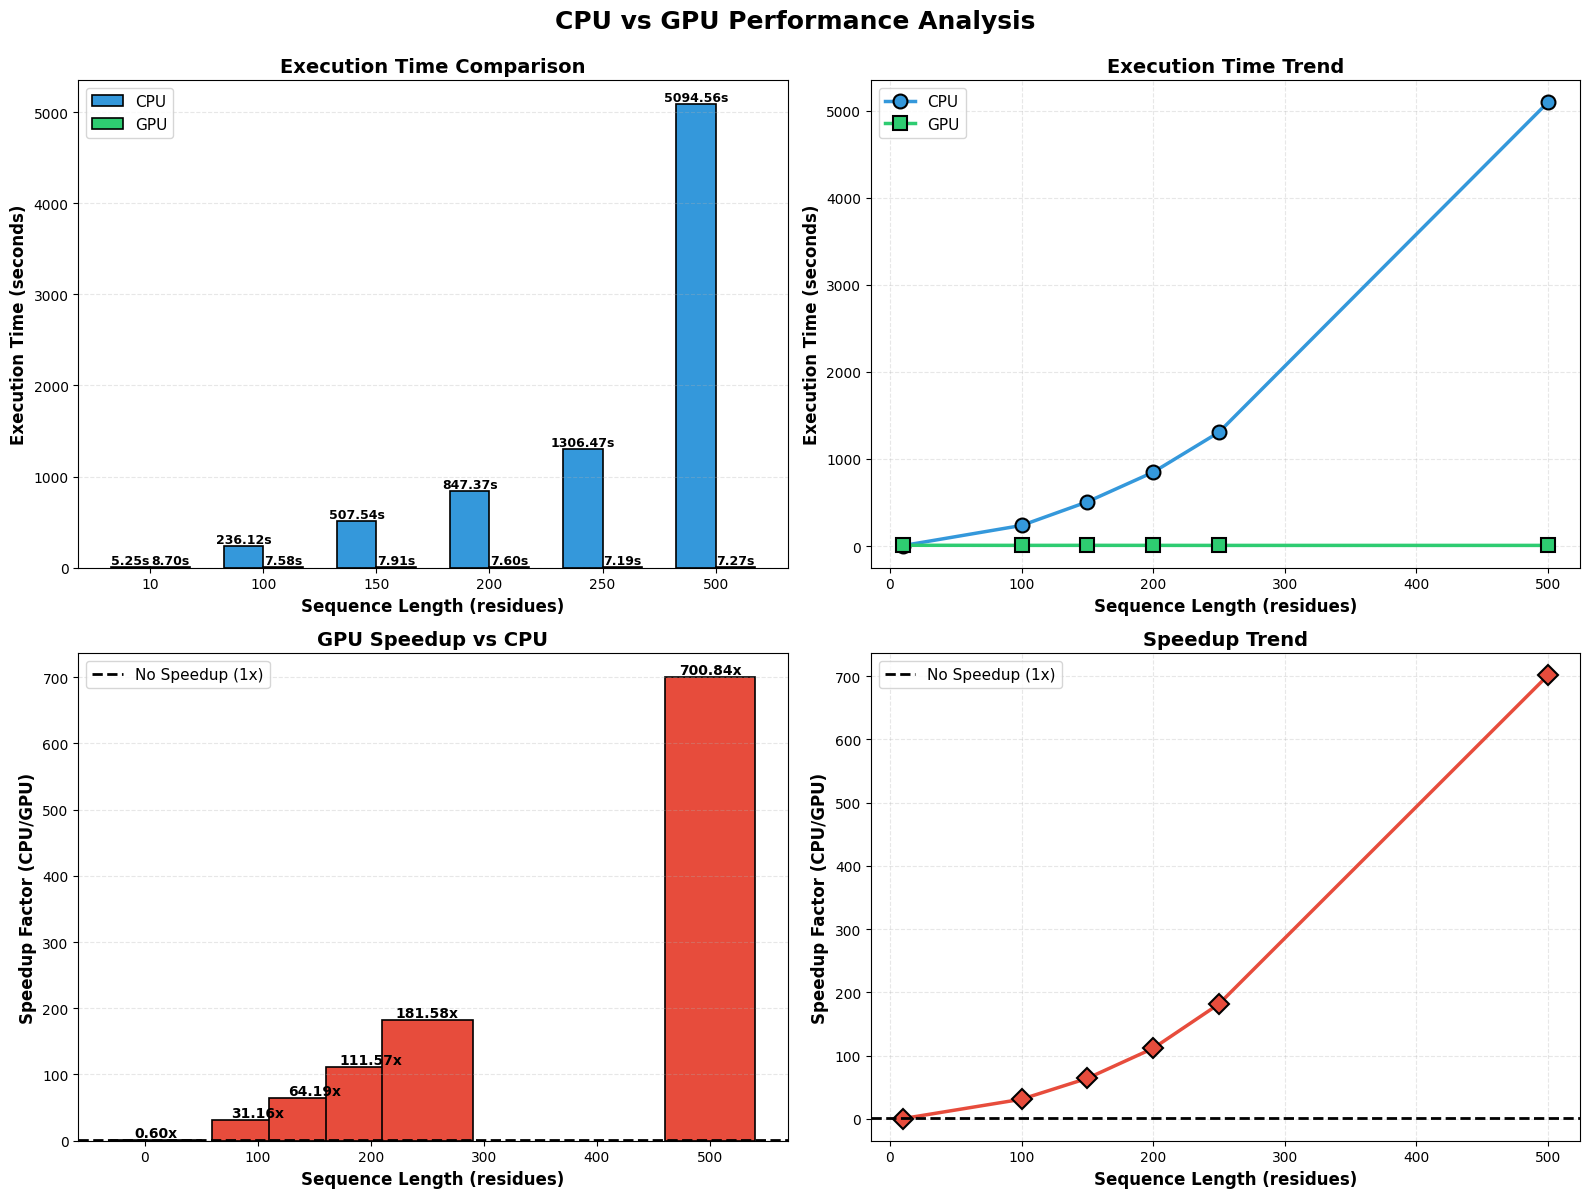

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CPU vs GPU Performance Analysis', fontsize=18, fontweight='bold', y=0.995)

ax1 = axes[0, 0]
x_pos = np.arange(len(sequence_lengths))
width = 0.35
bars1 = ax1.bar(x_pos - width/2, cpu_times, width, label='CPU', color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x_pos + width/2, gpu_times, width, label='GPU', color='#2ecc71', edgecolor='black', linewidth=1.2)

ax1.set_xlabel('Sequence Length (residues)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Execution Time Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(sequence_lengths)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2 = axes[0, 1]
ax2.plot(sequence_lengths, cpu_times, marker='o', linewidth=2.5, markersize=10,
         label='CPU', color='#3498db', markeredgecolor='black', markeredgewidth=1.5)
ax2.plot(sequence_lengths, gpu_times, marker='s', linewidth=2.5, markersize=10,
         label='GPU', color='#2ecc71', markeredgecolor='black', markeredgewidth=1.5)
ax2.set_xlabel('Sequence Length (residues)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Execution Time Trend', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, linestyle='--')

ax3 = axes[1, 0]
speedups = [cpu_times[i]/gpu_times[i] if gpu_times[i] > 0 else 0 for i in range(len(sequence_lengths))]
bars = ax3.bar(sequence_lengths, speedups, color='#e74c3c', edgecolor='black', linewidth=1.2, width=80)
ax3.axhline(y=1, color='black', linestyle='--', linewidth=2, label='No Speedup (1x)')
ax3.set_xlabel('Sequence Length (residues)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Speedup Factor (CPU/GPU)', fontsize=12, fontweight='bold')
ax3.set_title('GPU Speedup vs CPU', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax4 = axes[1, 1]
ax4.plot(sequence_lengths, speedups, marker='D', linewidth=2.5, markersize=10,
         color='#e74c3c', markeredgecolor='black', markeredgewidth=1.5)
ax4.axhline(y=1, color='black', linestyle='--', linewidth=2, label='No Speedup (1x)')
ax4.set_xlabel('Sequence Length (residues)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Speedup Factor (CPU/GPU)', fontsize=12, fontweight='bold')
ax4.set_title('Speedup Trend', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


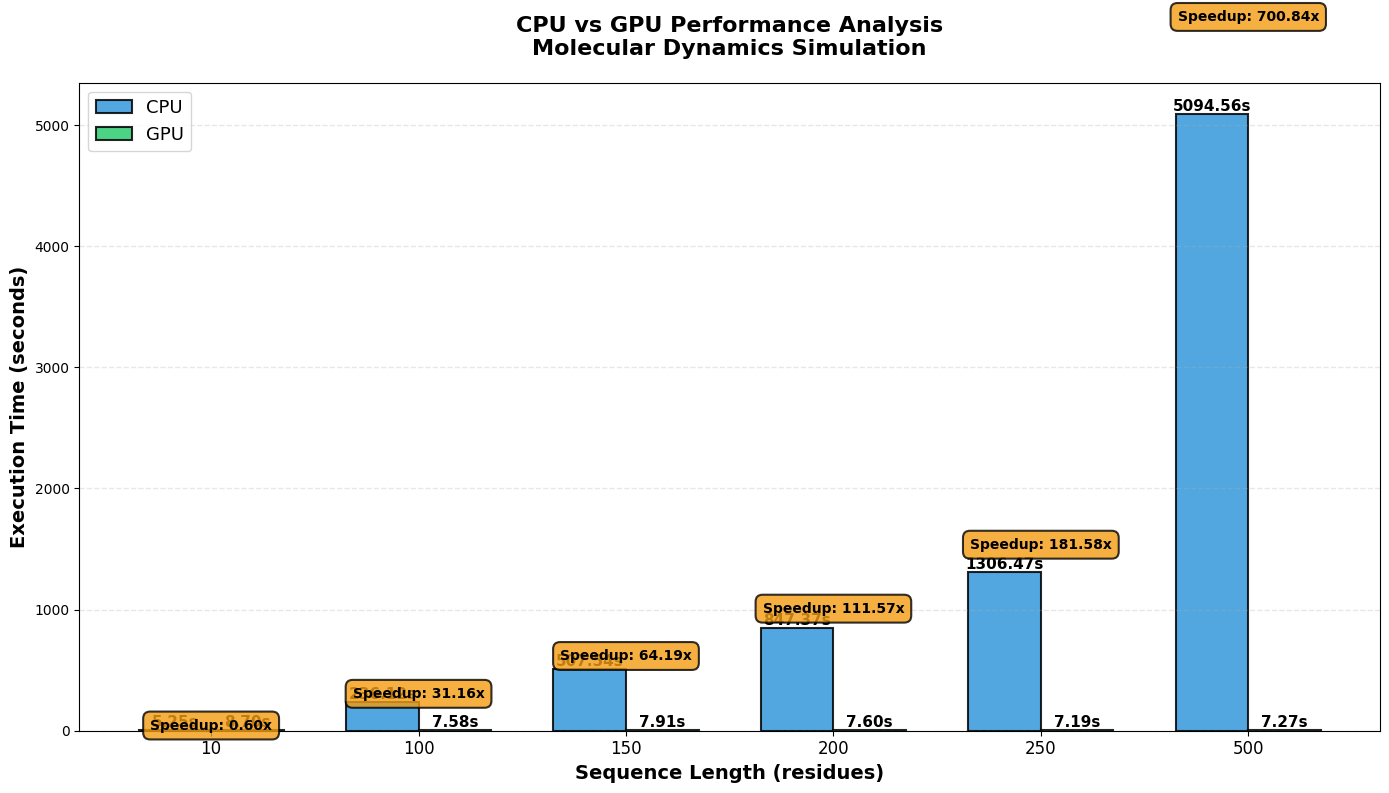

In [73]:
fig, ax = plt.subplots(figsize=(14, 8))

x_pos = np.arange(len(sequence_lengths))
width = 0.35

bars1 = ax.bar(x_pos - width/2, cpu_times, width, label='CPU',
               color='#3498db', edgecolor='black', linewidth=1.5, alpha=0.85)
bars2 = ax.bar(x_pos + width/2, gpu_times, width, label='GPU',
               color='#2ecc71', edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_xlabel('Sequence Length (residues)', fontsize=14, fontweight='bold')
ax.set_ylabel('Execution Time (seconds)', fontsize=14, fontweight='bold')
ax.set_title('CPU vs GPU Performance Analysis\nMolecular Dynamics Simulation',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(sequence_lengths, fontsize=12)
ax.legend(fontsize=13, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

for i, n_res in enumerate(sequence_lengths):
    speedup = cpu_times[i] / gpu_times[i] if gpu_times[i] > 0 else 0
    ax.text(i, max(cpu_times[i], gpu_times[i]) * 1.15,
            f'Speedup: {speedup:.2f}x',
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#f39c12',
                     edgecolor='black', linewidth=1.5, alpha=0.8))

plt.tight_layout()
plt.show()


In [74]:
print("\n" + "="*70)
print("MOLECULAR STRUCTURE VISUALIZATION FOR ALL SEQUENCES")
print("="*70)



MOLECULAR STRUCTURE VISUALIZATION FOR ALL SEQUENCES



CPU Simulation Results:

Sequence Length: 10 residues


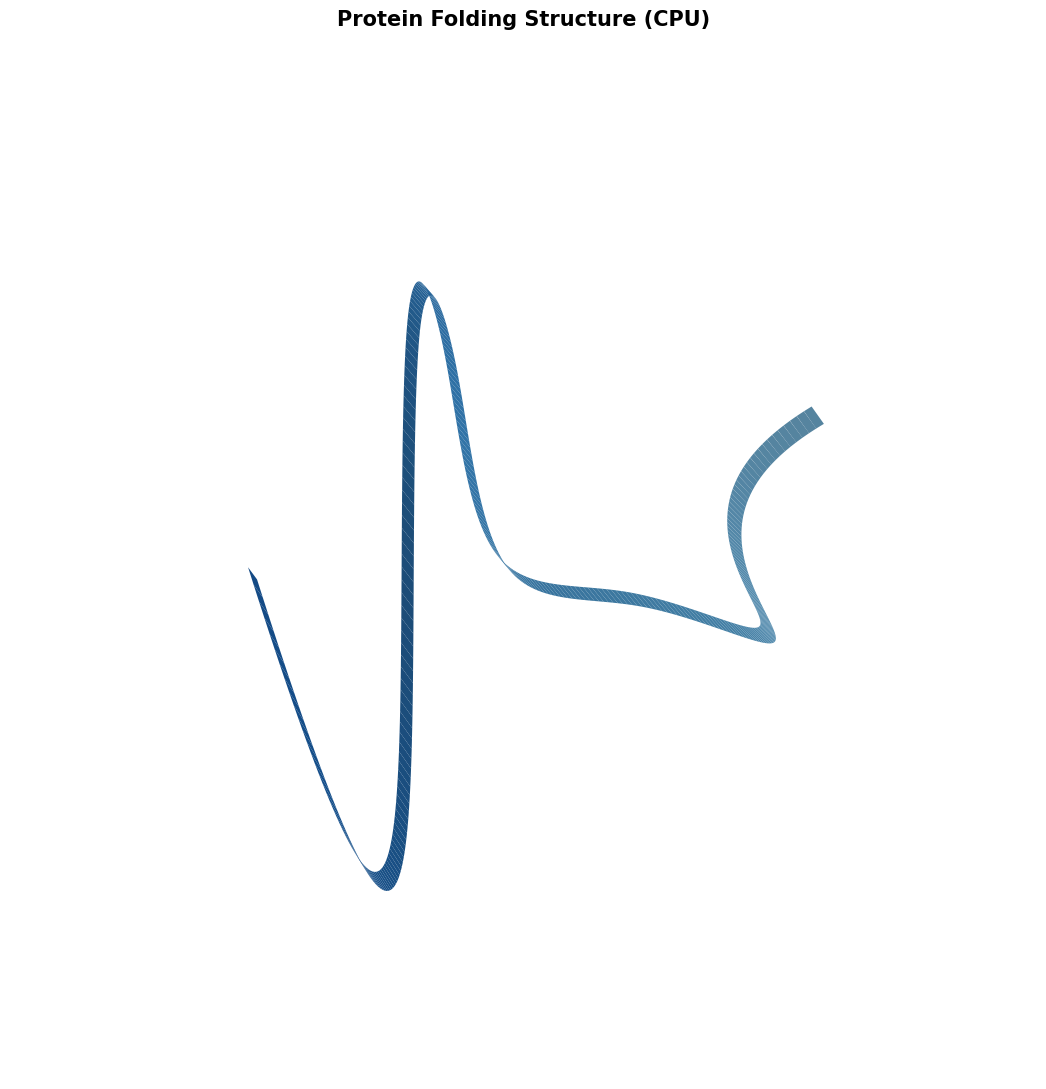


Sequence Length: 100 residues


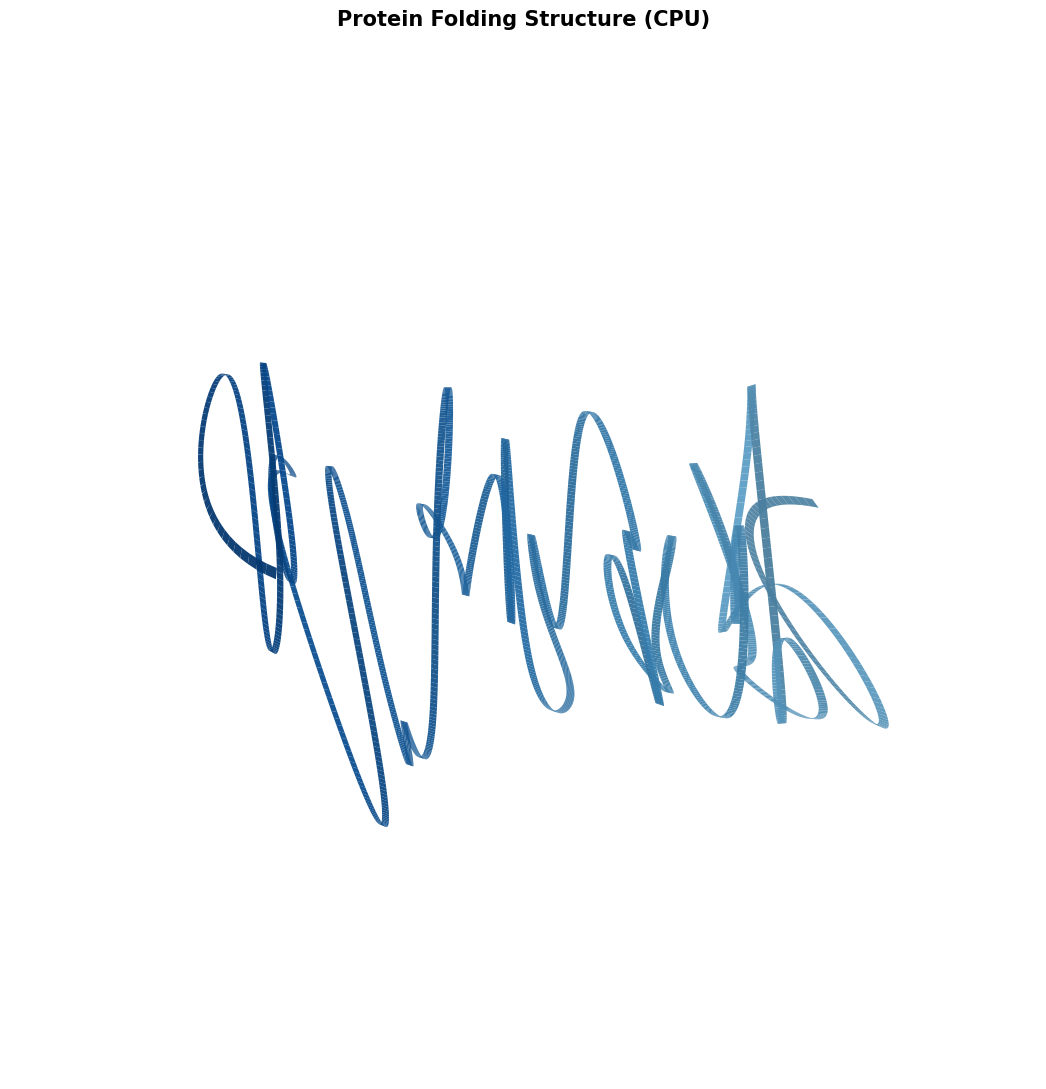


Sequence Length: 150 residues


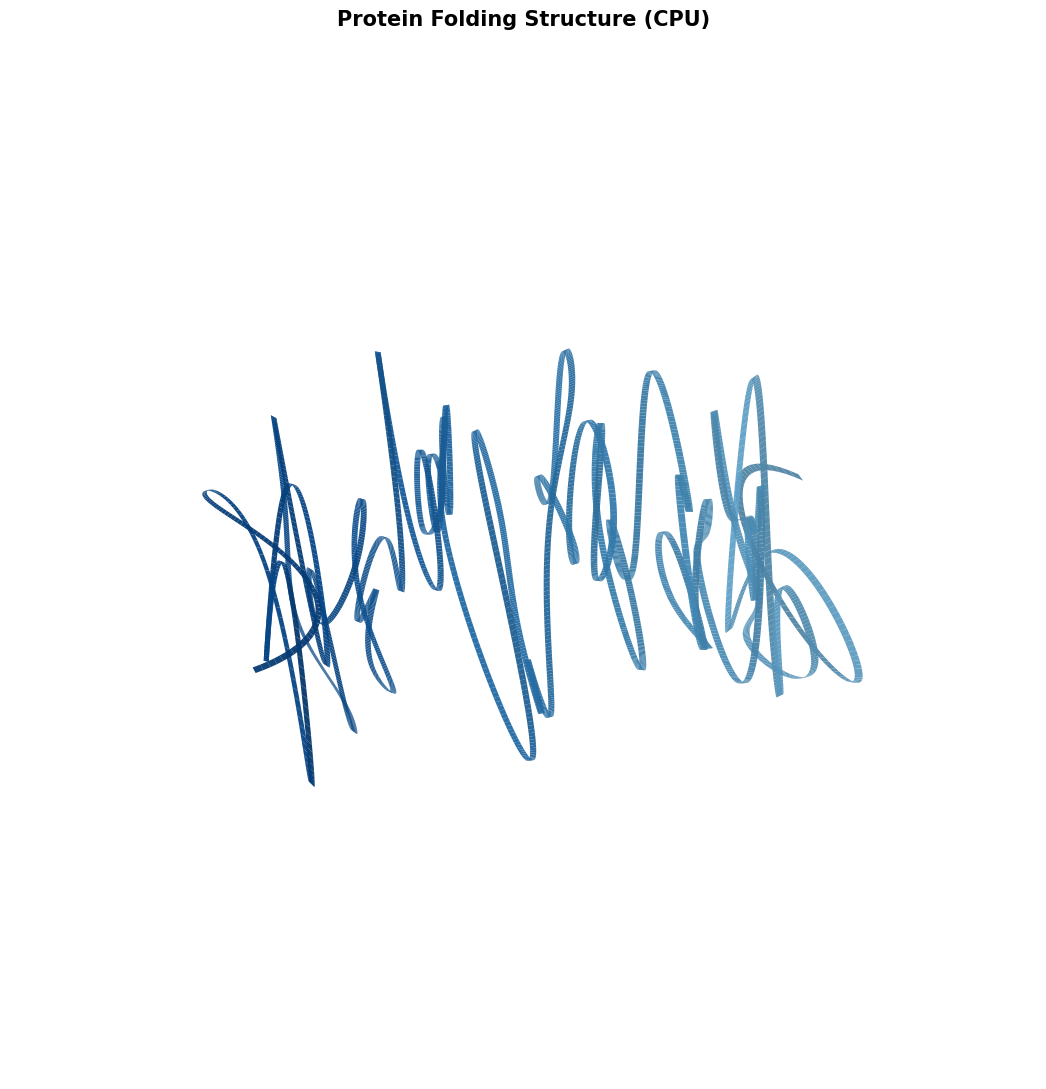


Sequence Length: 200 residues


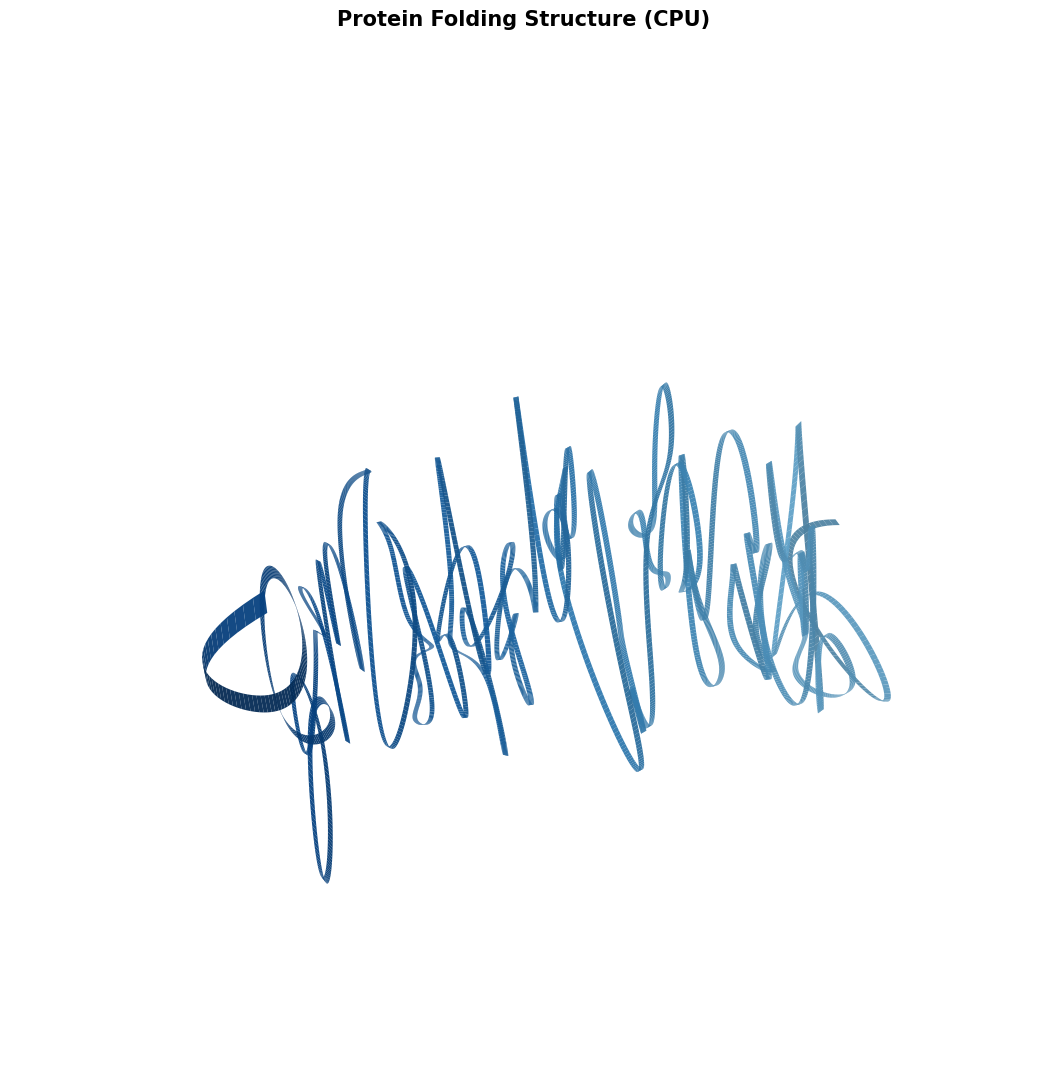


Sequence Length: 250 residues


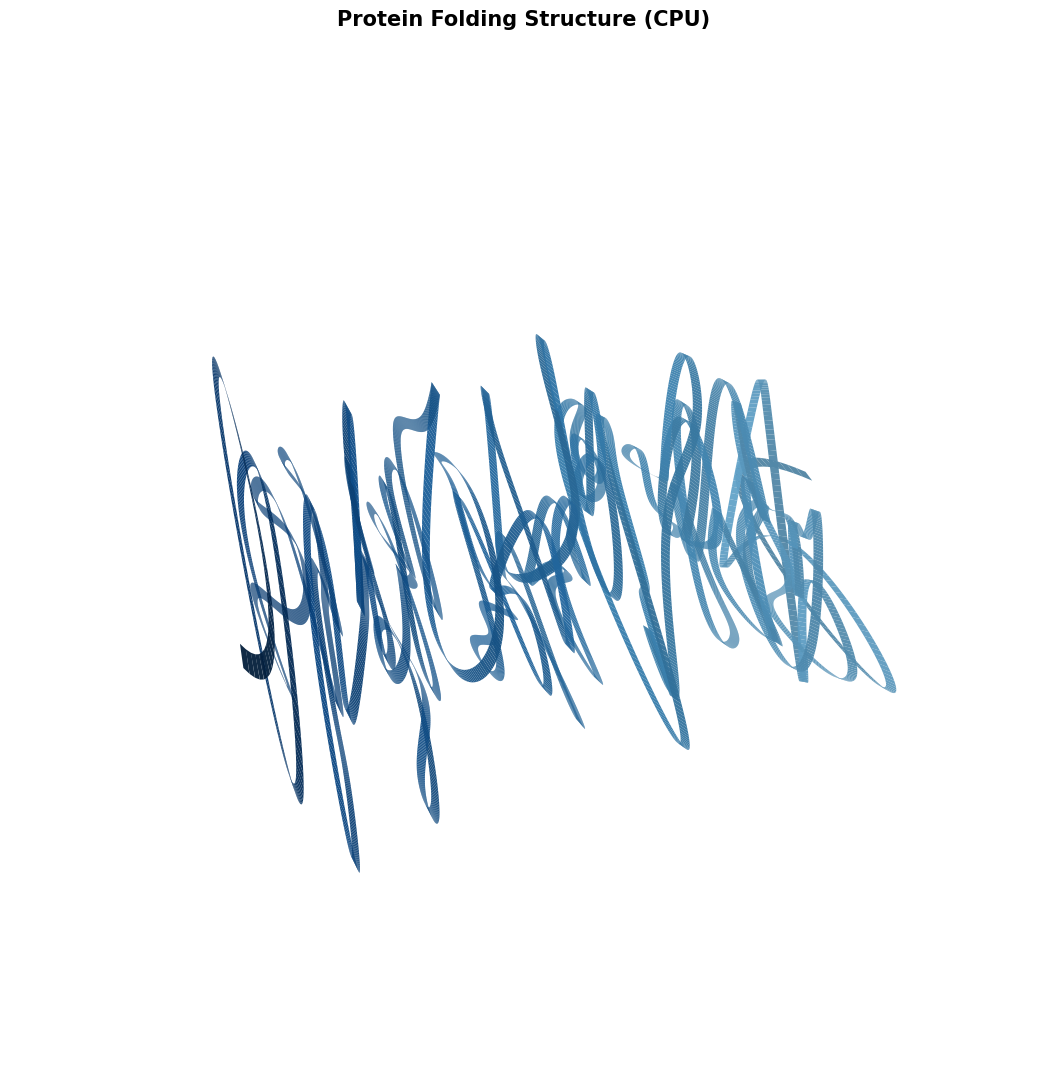


Sequence Length: 500 residues


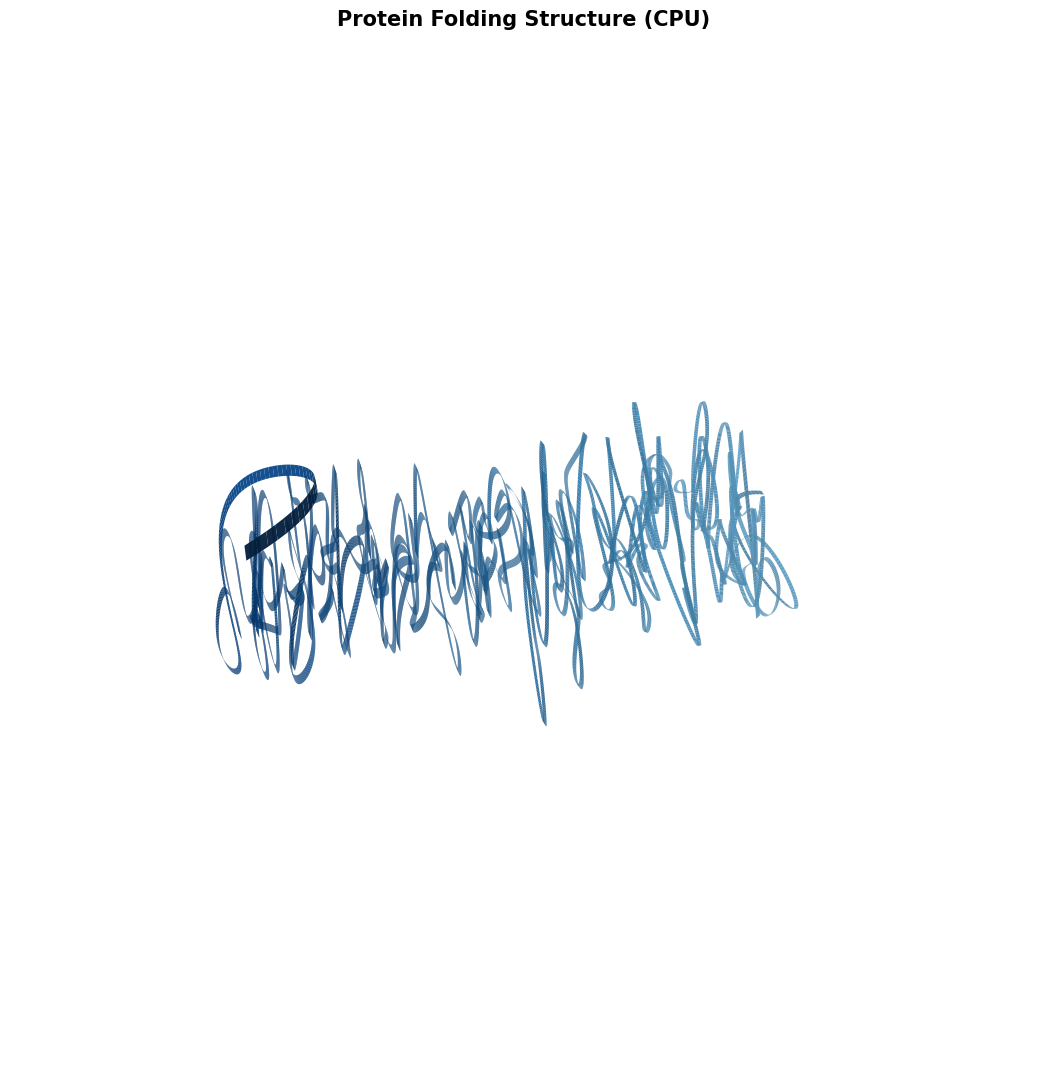

In [75]:
print("\nCPU Simulation Results:")
print("="*70)
for i, (n_res, cpu_sim) in enumerate(zip(sequence_lengths, cpu_simulations)):
    print(f"\nSequence Length: {n_res} residues")
    cpu_sim.plot_results()



GPU Simulation Results:

Sequence Length: 10 residues


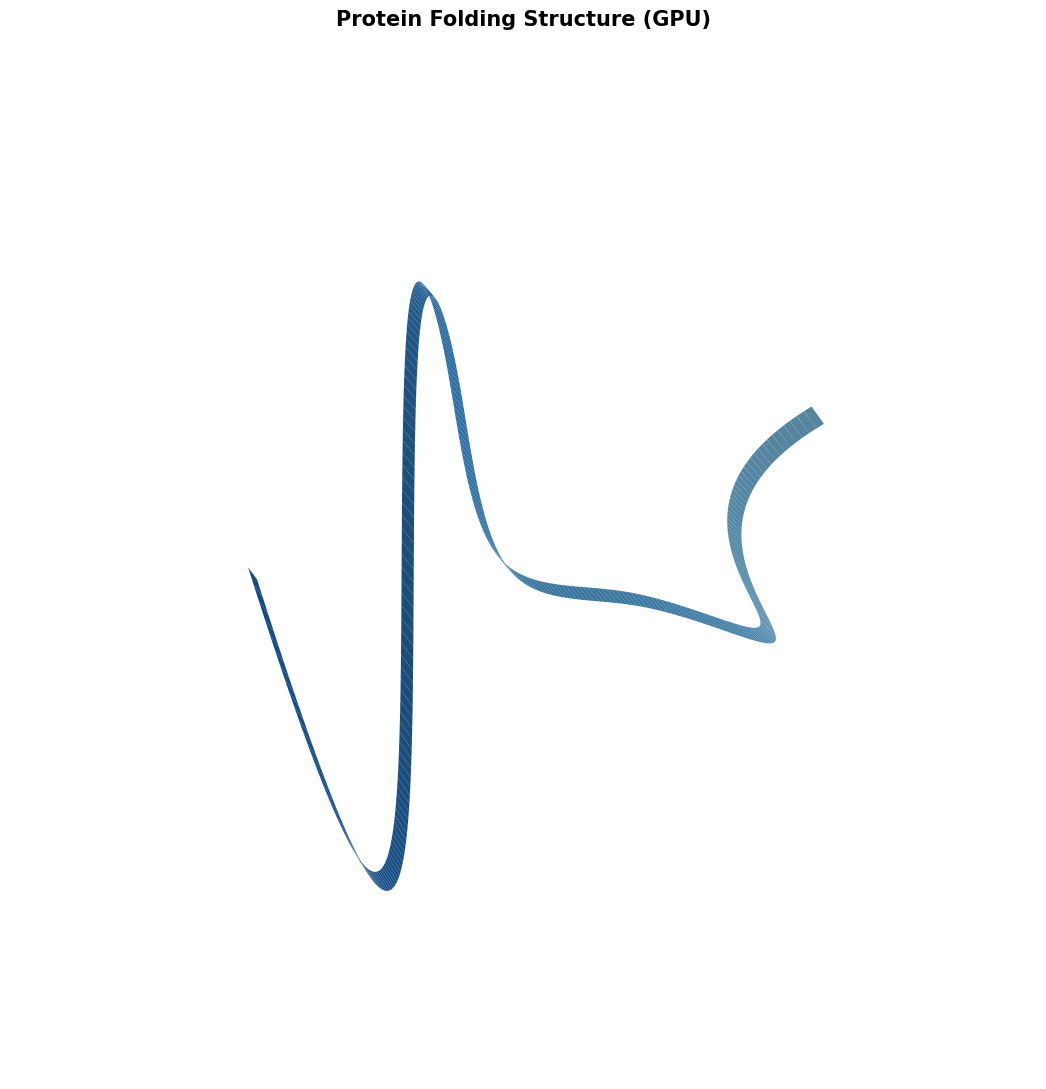


Sequence Length: 100 residues


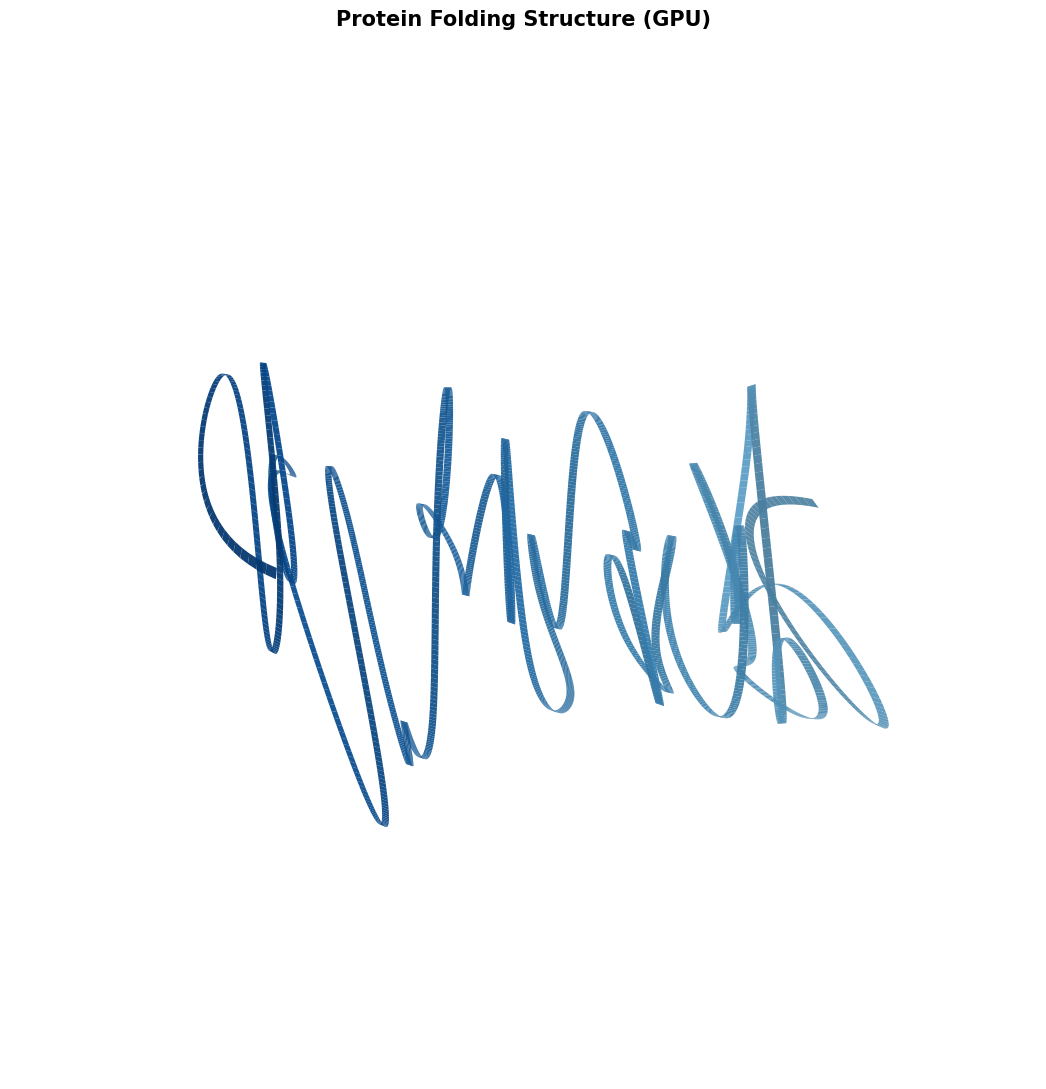


Sequence Length: 150 residues


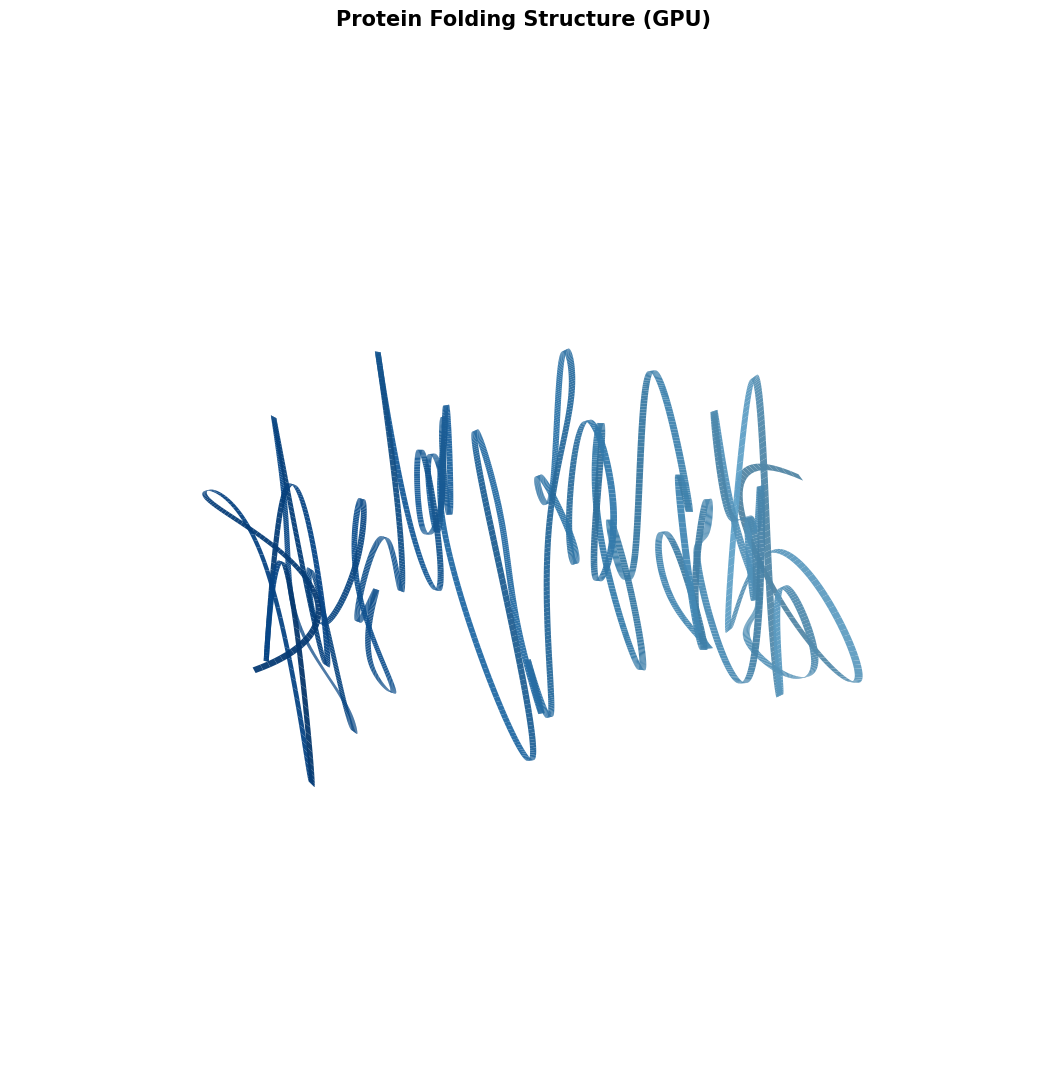


Sequence Length: 200 residues


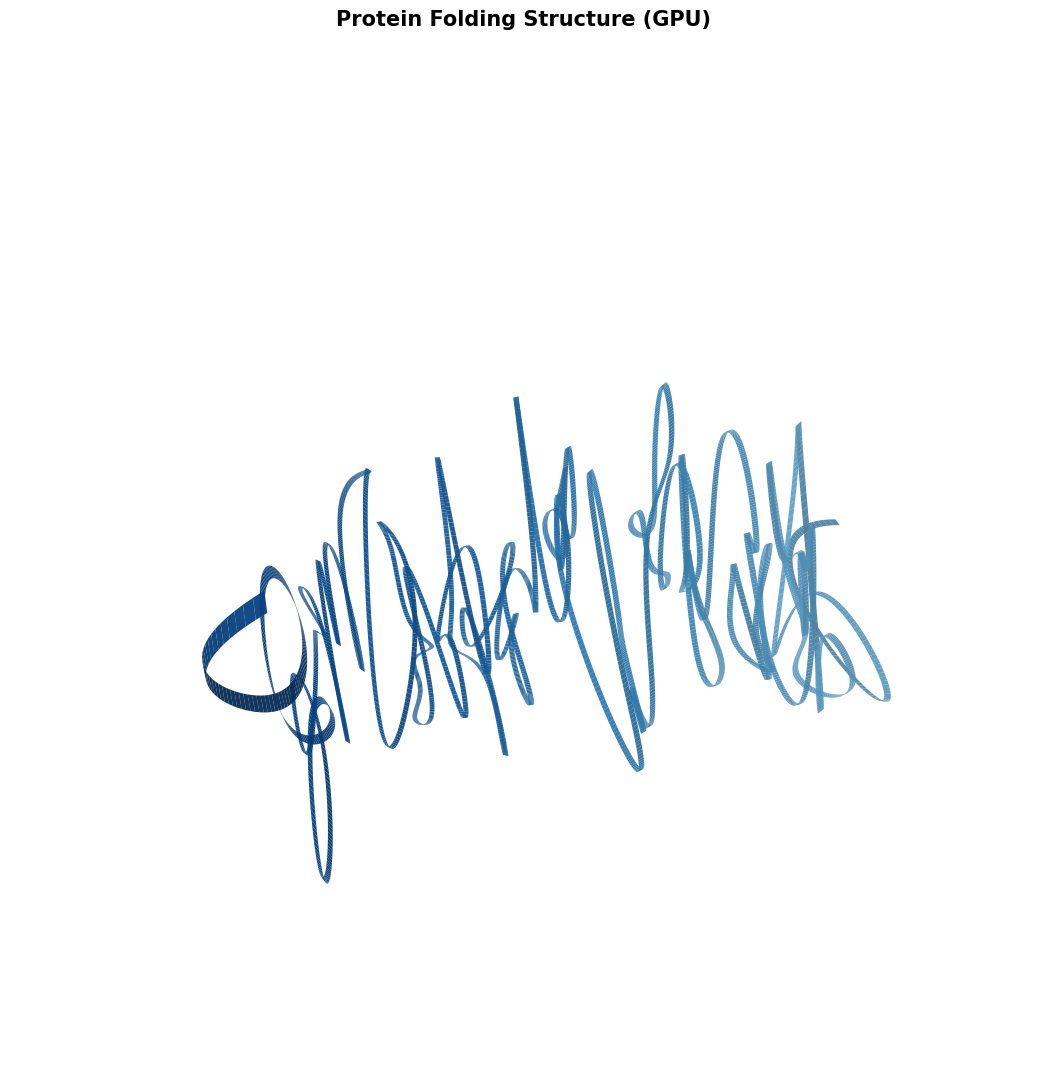


Sequence Length: 250 residues


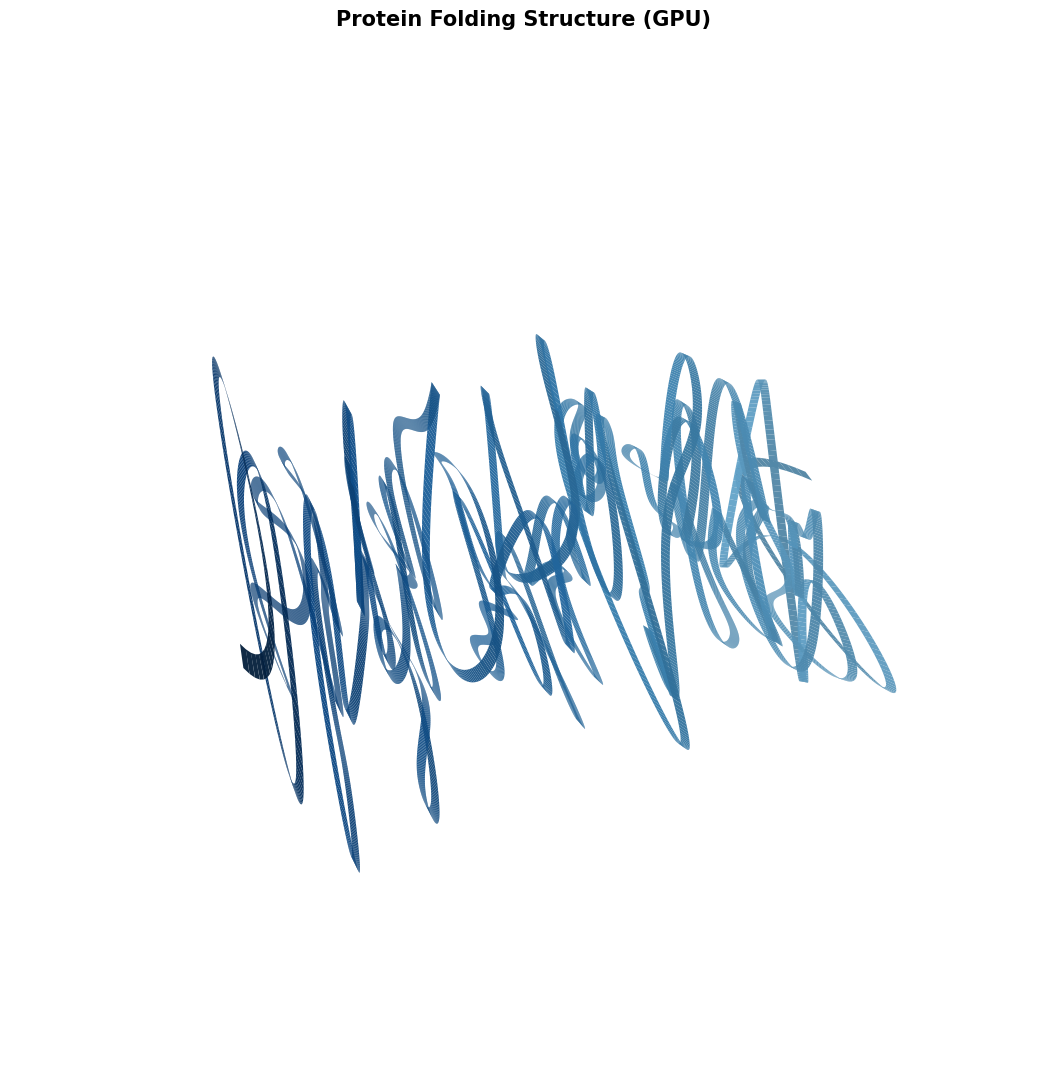


Sequence Length: 500 residues


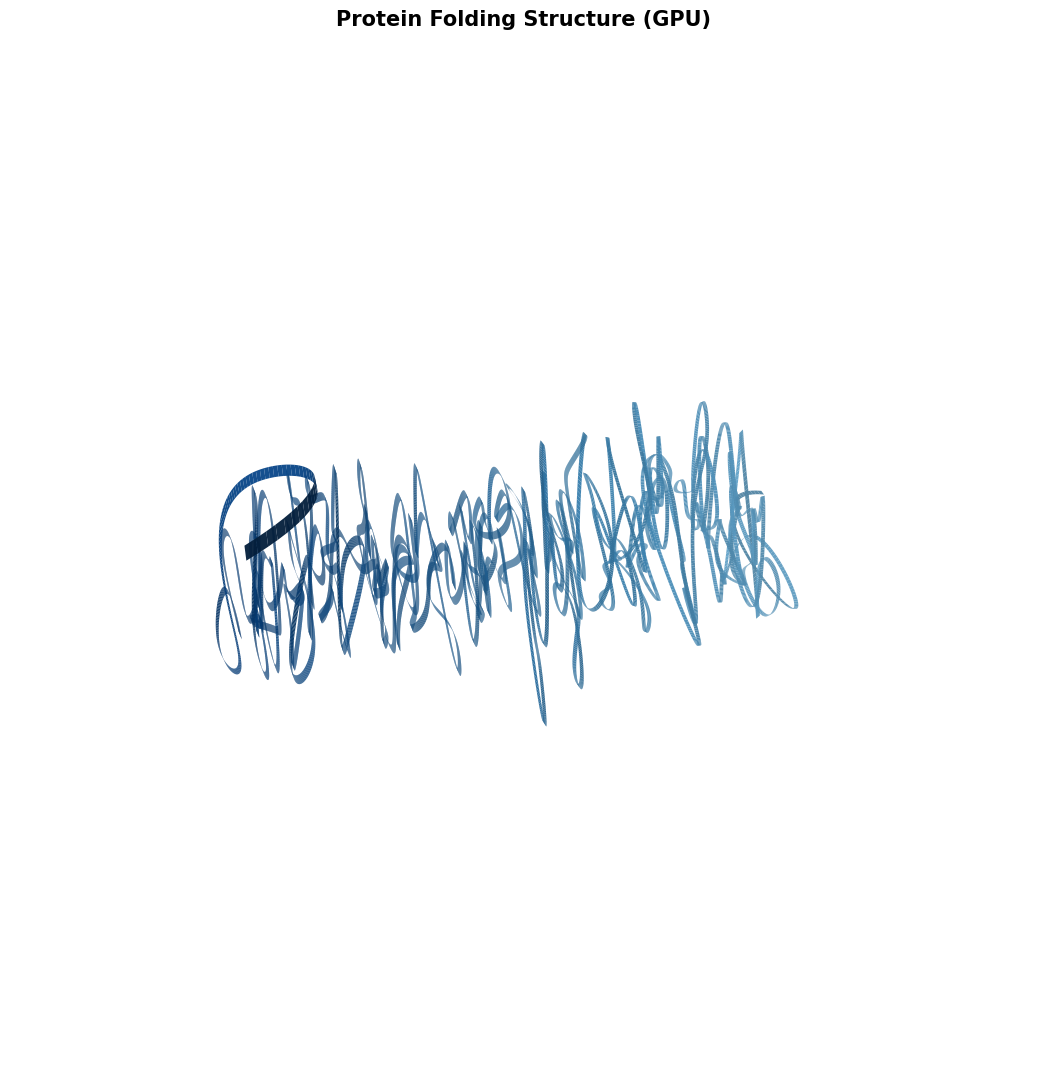

In [76]:
print("\nGPU Simulation Results:")
print("="*70)
for i, (n_res, gpu_sim) in enumerate(zip(sequence_lengths, gpu_simulations)):
    print(f"\nSequence Length: {n_res} residues")
    gpu_sim.plot_results()


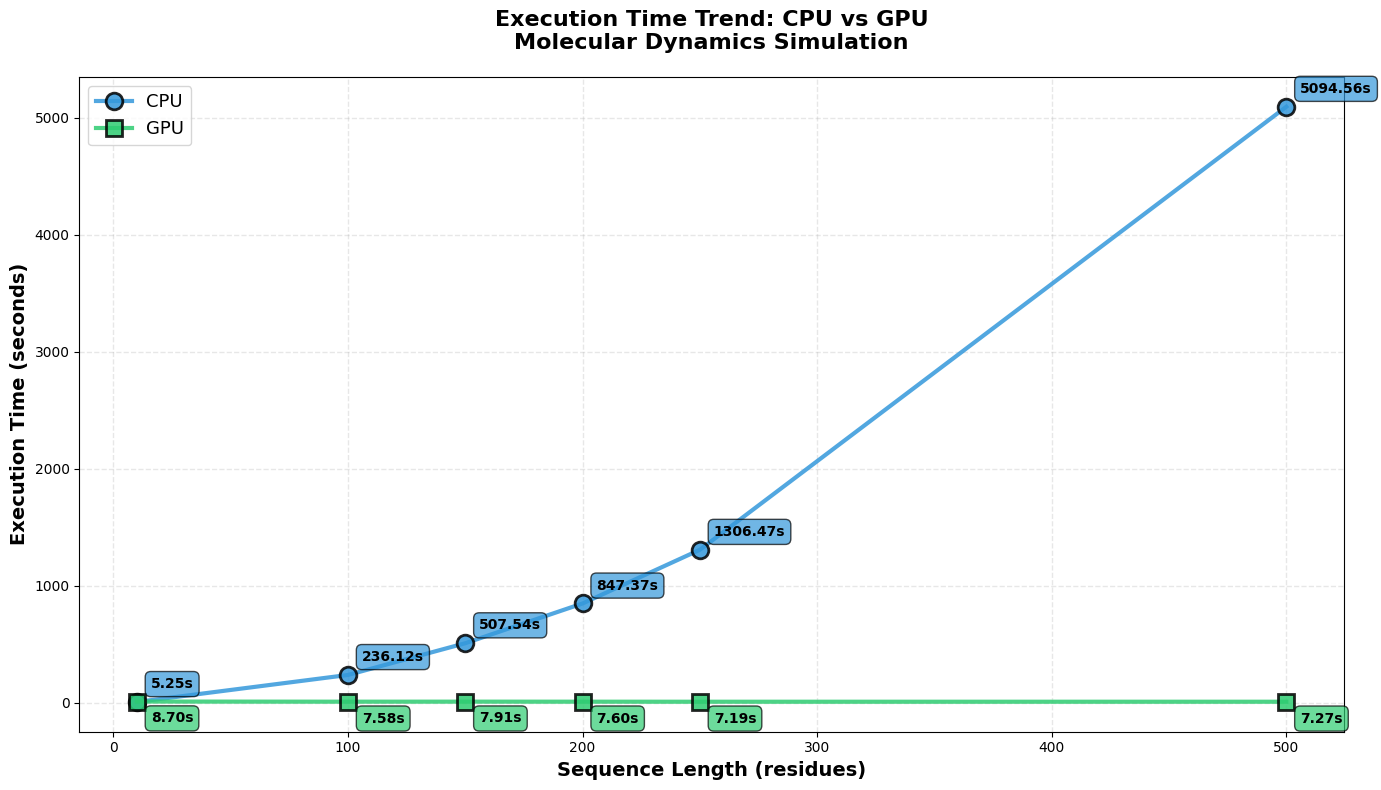

In [77]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(sequence_lengths, cpu_times, marker='o', linewidth=3, markersize=12,
        label='CPU', color='#3498db', markeredgecolor='black',
        markeredgewidth=2, linestyle='-', alpha=0.85)
ax.plot(sequence_lengths, gpu_times, marker='s', linewidth=3, markersize=12,
        label='GPU', color='#2ecc71', markeredgecolor='black',
        markeredgewidth=2, linestyle='-', alpha=0.85)

ax.set_xlabel('Sequence Length (residues)', fontsize=14, fontweight='bold')
ax.set_ylabel('Execution Time (seconds)', fontsize=14, fontweight='bold')
ax.set_title('Execution Time Trend: CPU vs GPU\nMolecular Dynamics Simulation',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=13, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)

for i, (n_res, cpu_t, gpu_t) in enumerate(zip(sequence_lengths, cpu_times, gpu_times)):
    ax.annotate(f'{cpu_t:.2f}s',
                xy=(n_res, cpu_t),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='#3498db',
                         edgecolor='black', linewidth=1, alpha=0.7))

    ax.annotate(f'{gpu_t:.2f}s',
                xy=(n_res, gpu_t),
                xytext=(10, -15),
                textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='#2ecc71',
                         edgecolor='black', linewidth=1, alpha=0.7))

plt.tight_layout()
plt.show()
